<a href="https://colab.research.google.com/github/cirilwakounig/MachineLearning/blob/main/5_Hyperparameter_Tuning_using_Cross_Validation_and_Pipelining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extending a Pipeling with Cross-Validation

Cross-validation can be used, to better assess the performance of a model on a given data set. While the train-test-split is useful to test a model's performance, there is still some random chance, that a certain test set is better suited for the developed model. To prevent such randomness, the cross-validation approach, where multiple subsets of data are used to assess the performance of the model, is used. So-called holdout-sets (or folds) are the validation set, while the remaining data is used to train the model. This analysis is then redone for multiple folds, where each fold is constituted by a different subset of the total data.

> When should Cross-Validation be used?
As performing cross-validation is computationally expensive, there are limitations to its benefit. 

*   For small datasets, where extra computational burden is not a big deal, cross-validation can be performed.
*   For larger data sets, a single validation is sufficient, as the validation set already represents the entirety of the dataset. 




In [ ]:
# Import the required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Pipelining
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model Development and Validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

#### 1. Import and Process the required Data

---



##### 1.1 Import of Data

In [ ]:
# Import the Data Set Set
file_path_train = '/content/drive/MyDrive/Colab Notebooks/Kaggle Course/Intermediate Machine Learning/train.csv'
file_path_test = '/content/drive/MyDrive/Colab Notebooks/Kaggle Course/Intermediate Machine Learning/test.csv'

# Read the data
train_data = pd.read_csv(file_path_train, index_col = 'Id')
test_data = pd.read_csv(file_path_test, index_col = 'Id')

# Remove missing target values
train_data.dropna(axis = 0, subset = ['SalePrice'], inplace = True)   # Inplace = True overrides existing data frame
# Assign the dependent variable 
y = train_data.SalePrice

# Separate features from target
train_data.drop(['SalePrice'], axis = 1, inplace = True)

##### 1.2 Defining Categorical and Numerical Columns

Differentiate between categorical and numerical columns.

In [ ]:
# Cardinality refers to the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in train_data.columns if 
                    train_data[cname].nunique() < 10 and 
                    train_data[cname].dtype == 'object']

# Select numerical columns
numerical_cols = [cname for cname in train_data.columns if 
                  train_data[cname].dtype in ['int64', 'float64']]



> For simplicity, categorical variables are dropped. 





In [ ]:
# Select only numerical columns for the data
X = train_data[numerical_cols].copy()
X_test = test_data[numerical_cols].copy()

X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008


#### 2. Develop the Pipeline

---

In this section, a pipeline containing preprocessing and model development will be created. 

As only numerical data is being used, the setup of this pipeline is simple. The preprocessing step of the pipeline only consists of the SimpleImputer() function found in sklearn. The model will consist of a RandomForestRegressor using 50 estimators. 

In [ ]:
# Define Preprocessor
preprocessor = SimpleImputer()

# Define Model
model = RandomForestRegressor(n_estimators = 50, random_state = 0)

# Consolidate Preprocessing and Model Development
my_pipe = Pipeline(steps = [('preprocessor', preprocessor),
                            ('model', model)])

#### 3. Performing Cross-Validation


---

After having created the pipeline, it can be used for cross-validation. 

In [ ]:
# Multiply the result with -1, since sklearn calculates a negative MAE
scores = -1 * cross_val_score(my_pipe, X, y, 
                              cv = 5, scoring = 'neg_mean_absolute_error')

# Average over all scores to get the mean score over all folds
print('Average MAE score for CV:', scores.mean())

Average MAE score for CV: 18276.410356164386


#### 4. Writing a function that consolidates the pipeline and cross-validation.

---



##### 4.1 Function Definition

In [ ]:
# This function contains both the pipeline statement as well as the cross-validation
def get_score(n_estimators, X, y):
    
    ### Pipeline
    # Preprocessor
    preprocessor = SimpleImputer()
    
    # Model
    model = RandomForestRegressor(n_estimators = n_estimators, random_state = 0)
    
    # Pipeline Statement
    my_pipe = Pipeline(steps = [('preprocessor', preprocessor), 
                                ('model', model)])
    
    ### Cross-Validation
    scores = -1 * cross_val_score(my_pipe, X, y,
                                 cv = 3, scoring = 'neg_mean_absolute_error')

    return (scores.mean())

##### 4.2. Function Application

In [ ]:
# Iterating over the number of estimators allows a comparison of model performance
results = []
no_estimators = np.linspace(50,400,8,endpoint = True, dtype = 'Int64')

# Loop over the number of estimators and run the cross-validation-pipeline
for i in no_estimators:
  results.append(get_score(i,X,y))

##### 4.3 Display of Results

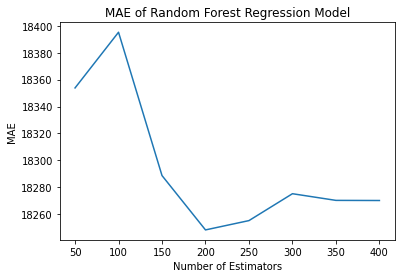

In [ ]:
# The results of the hyperparameter tuning are shown below
plt.plot(no_estimators, results)
plt.xlabel('Number of Estimators')
plt.ylabel('MAE')
plt.title('MAE of Random Forest Regression Model')
plt.show()

##### 4.4 Optimal Hyperparameter

In [ ]:
# The optimal n_estimator value can be computed as follows
opt_hyper = no_estimators[results.index(min(results))]

print('The optimal number of estimators is:', opt_hyper)

The optimal number of estimators is: 200
